# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
ё- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

In [182]:
# ячейка со всеми импортами
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import pymorphy3
from nltk import bigrams, trigrams
from nltk.corpus import stopwords
ru_stopwords = stopwords.words("russian")
from bs4 import BeautifulSoup
import re
from collections import Counter
from gensim import corpora
from gensim.models import TfidfModel
from gensim.parsing.preprocessing import preprocess_string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

In [2]:
data = pd.read_csv('parsed_reviews3.csv', sep = ',', encoding='utf-8')
data['rating'] = data['rating'].astype(int)
data['date'] = pd.to_datetime(data['date'])
print(f'В исходном датафрейма {data.shape[0]} строк и {data.shape[1]} столбцов')
data.head(5)

В исходном датафрейма 92735 строк и 5 столбцов


,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36


Для начала поищем странности в исходных данных

In [3]:
# нет ни одного NaN - это хорошо
data.isnull().any()

body         False
title        False
rating       False
bank_name    False
date         False
dtype: bool

In [4]:
# с типами данных тоже все в порядке
data.dtypes

body                 object
title                object
rating                int32
bank_name            object
date         datetime64[ns]
dtype: object

In [5]:
# но есть дубликаты
data.duplicated().any()

True

In [6]:
# посмотрим на них
print(f'В датафрейме {data[data.duplicated()].shape[0]} дубликатов')
data[data.duplicated()].head(5)

В датафрейме 62 дубликатов


,body,title,rating,bank_name,date
899,&lt;p&gt;Обратился 3 декабря в районе 19 часов...,открытие счёта и получение банковской карты,5,Хоум Кредит Банк,2022-12-30 16:16:13
997,&lt;p&gt;С самого открытия являемся клиентами ...,"Сняли деньги за перевод физ.лицу, а услугу не ...",1,Норвик Банк,2022-12-30 14:06:33
1611,&lt;p&gt;22.12.2022 в чате своего ЛК мобильног...,Отсутствие информации о порядке конвертации ва...,2,Росбанк,2022-12-29 15:03:06
2502,"&lt;p&gt;Оформлял рассрочку на телефон, в мага...",Лучший кредитный банк,5,Хоум Кредит Банк,2022-12-28 13:44:16
2504,&lt;p&gt;28 декабря я посетил банк МКБ по адре...,Отличное обслуживание,5,Московский Кредитный Банк,2022-12-28 13:42:41


In [7]:
# удалим дубликаты
data = data.drop_duplicates()

На первый взгляд в датасете нет каких-то явно выраженных аномалий, так что можно перейти к ответам на поставленные вопросы:

1. **Назвать топ-15 банков по числу отзывов**

In [8]:
# топ-15 банков по числу отзывов
banks_reviews_and_rating = data.groupby(['bank_name']).agg({'body':'count', 'rating': 'mean'}).reset_index()
banks_reviews_and_rating.columns = ['bank_name', 'count', 'rating']
banks_reviews_and_rating['rating'] = banks_reviews_and_rating['rating'].round(2)
banks_reviews_and_rating.sort_values(by='count', ascending=False, inplace=True)
top15_banks_by_count = banks_reviews_and_rating.head(15).reset_index(drop=True)
top15_banks_by_count

,bank_name,count,rating
0,Тинькофф Банк,44852,4.78
1,Хоум Кредит Банк,9301,4.51
2,Совкомбанк,6100,4.26
3,ВТБ,3814,1.95
4,СберБанк,3487,2.30
5,Альфа-Банк,3368,1.71
6,Россельхозбанк,3062,4.46
7,Банк Открытие,1894,3.54
8,МТС Банк,1542,2.90
9,Модульбанк,1452,4.78


2. **Назвать банк с самым высоким рейтингом из числа топ-15 банков по отзывам**

In [9]:
top15_banks_by_count.sort_values(by='rating', ascending=False).head(1)

,bank_name,count,rating
0,Тинькофф Банк,44852,4.78


3. **Сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов**

In [10]:
# сначала распарсим колонку date - пригодится для дальнейшего анализа
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute
data['second'] = data['date'].dt.second

Построим график изменения среднего рейтинга по месяцам у топ-5 банков по числу отзывов

In [11]:
data['year_month'] = data['year'].astype(str) + '-' + data['month'].astype(str)
data_to_graph = data[['bank_name','year_month','rating']]
data_to_graph = data_to_graph[data_to_graph['bank_name'].isin(top15_banks_by_count.head(5)['bank_name'])].groupby(['bank_name', 'year_month']).agg({'rating': 'mean'}).reset_index()
data_to_graph['rating'] = data_to_graph['rating'].round(2)
order = ['2022-9', '2022-10', '2022-11', '2022-12', '2023-1']
data_to_graph['year_month'] = pd.Categorical(data_to_graph['year_month'], categories=order, ordered=True)
data_to_graph = data_to_graph.sort_values(by=['bank_name', 'year_month']).reset_index(drop=True)
data_to_graph.head(10)

,bank_name,year_month,rating
0,ВТБ,2022-9,2.07
1,ВТБ,2022-10,1.91
2,ВТБ,2022-11,1.99
3,ВТБ,2022-12,1.90
4,ВТБ,2023-1,1.15
5,СберБанк,2022-9,1.92
6,СберБанк,2022-10,2.78
7,СберБанк,2022-11,2.56
8,СберБанк,2022-12,1.87
9,СберБанк,2023-1,1.40


Я сразу обратила внимание на то, что в январе рейтинг сильно ниже, чем в другие месяцы.

In [12]:
print("Дни в январе, в который оставили отзывы:", *data[(data['month'] == 1)]['day'].unique(), sep = " ")
data[data['bank_name'].isin(top15_banks_by_count.head(10)['bank_name'])].groupby(['bank_name', 'year_month']).agg({"body":"count"}).reset_index().head(15)

Дни в январе, в который оставили отзывы: 3 2 1


,bank_name,year_month,body
0,Альфа-Банк,2022-10,826
1,Альфа-Банк,2022-11,1076
2,Альфа-Банк,2022-12,803
3,Альфа-Банк,2022-9,634
4,Альфа-Банк,2023-1,29
5,Банк Открытие,2022-10,437
6,Банк Открытие,2022-11,639
7,Банк Открытие,2022-12,525
8,Банк Открытие,2022-9,283
9,Банк Открытие,2023-1,10


Если посмотреть на распределение отзывов по месяцам, то увидим, что оно очень неравномерное.
Это потому, что у нас есть отзывы только на первые три дня января.

Поэтому, когда я буду писать выводы, я не буду ничего говорить про январь, и на графике я тоже его показывать не буду.

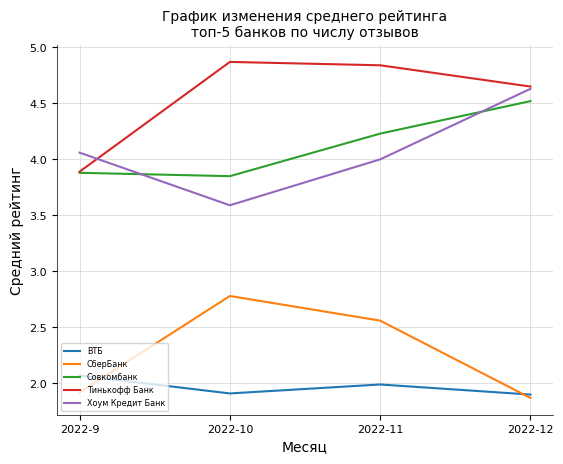

In [17]:
data_to_graph = data_to_graph[data_to_graph['year_month'] != '2023-1']
banks = data_to_graph['bank_name'].unique()
for b in banks:
    bank_data = data_to_graph[data_to_graph['bank_name'] == b]
    plt.plot(bank_data['year_month'], bank_data['rating'], label=b)
plt.title('График изменения среднего рейтинга\nтоп-5 банков по числу отзывов', fontsize=10)
plt.xlabel('Месяц')
plt.ylabel('Средний рейтинг')
plt.box(True)
plt.legend(fontsize='xx-small', loc='lower left')
plt.grid(True, linestyle='-', linewidth=0.5, color='lightgrey')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
plt.show()


##### **Выводы**

- Тинькофф, Совкомбанк и Хоум Кредит Банк имеют примерно одинаковый рейтинг в сентябре и декабре, несмотря на то, что в октябре рейтинг Тинькоффа сильно растет, а рейтинг Совкомбанка и ХКБ - резко падает 
- Рейтинги ВТБ и Сбербанка в целом намного ниже рейтинга остальных банков
- Сбер стремительно растет в октябре, но затем также стремительно падает в ноябре и декабре
- ВТБ - банк с самым низким средним рейтингом практически в каждом месяце. И если рейтинги других банков испытывают резкие изменения от месяца к месяцу, рейтинг ВТБ изменяется очень плавно, с небольшими колебаниями.

4. **Нет ли в данных в целом каких-то странностей на ваш взгляд?**

Одну странность я уже описала ранее - январских отзывов очень мало.

Самая большая странность, на мой взгляд, это то, что отзывов на Тинькофф банк в разы больше, чем отзывов на другие банки.
Причин этому может быть несколько. Это мог быть баг на этапе сбора данных, или, может быть, клиенты Тинькофф банка в целом чаще оставляют отзывы в интернете (все таки, Тинькофф - это мобильный банк, и его пользователи в принципе пользуются интернетом чаще, чем клиенты других банков, но это скорее мое личное мнение)

Так или иначе, дизбаланс есть, и это бесит, особенно когда доходит до текстового анализа, чуть позже покажу, почему.

5. **Дополнительный EDA**

Сейчас я хочу проанализироать временные данные.

Посмотрим, в какое время пишут отрицательные отзывы, а в какое - положительные

Я буду считать положительными отзывы >= 3, а отрицательными - <3, как сказано в задании

In [18]:
# сразу добавлю колонку "class": 0 - отзыв отрицательный, 1 - положительный. Это пригодится сейчас и на этапе с метрикой
data['class'] = data['rating'].apply(lambda x: 1 if x >= 3 else 0)

In [19]:
# делаю группировку по часу и рейтингу и считаю средний рейтинг
pos_and_neg_hour = data.groupby(['hour', 'class']).size().reset_index(name='count')
count_rating_pos = data[data['class'] == 1].shape[0]
count_rating_neg = data[data['class'] == 0].shape[0]
pos_and_neg_hour['percentage'] = pos_and_neg_hour.apply(lambda row: row[2]/count_rating_pos * 100 if row[1] == 1 else row[2]/count_rating_neg * 100, axis=1).round(2)
pos_and_neg_hour.head(6)

C:\Users\mayko\AppData\Local\Temp\ipykernel_15092\1257091007.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pos_and_neg_hour['percentage'] = pos_and_neg_hour.apply(lambda row: row[2]/count_rating_pos * 100 if row[1] == 1 else row[2]/count_rating_neg * 100, axis=1).round(2)


,hour,class,count,percentage
0,0,0,459,2.20
1,0,1,1664,2.32
2,1,0,277,1.33
3,1,1,1108,1.54
4,2,0,181,0.87
5,2,1,764,1.06


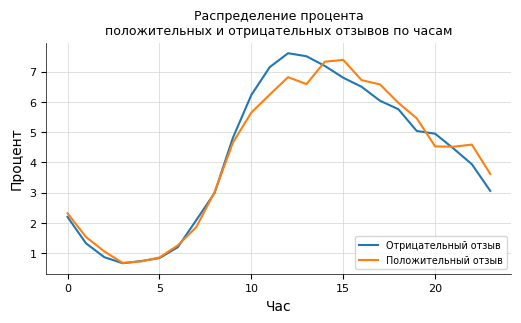

In [20]:
fig, ax = plt.subplots(figsize=(6, 3))
for c in [0, 1]:
    rating_data = pos_and_neg_hour[pos_and_neg_hour['class'] == c]
    ax.plot(rating_data['hour'], rating_data['percentage'], label='Положительный отзыв' if c == 1 else 'Отрицательный отзыв')

ax.set_xlabel('Час')
ax.set_ylabel('Процент')
ax.set_title('Распределение процента\nположительных и отрицательных отзывов по часам', fontsize=9)
ax.legend(fontsize='x-small', loc='lower right')
plt.grid(True, linestyle='-', linewidth=0.5, color='lightgrey')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
plt.show()


В целом, нет большой разницей между тем, в какое время люди пишут отзыв. Можно увидеть, что самое большое количество положительных отзывов пишут в районе 15 часов, а самое большое количество отрицательных отзывов пользователи оставляют около полудня.

**А сейчас минутка NLP**

Перед тем, как перейти к части с предсказанием оценки, я бы хотела провести небольшой анализ текста и посмотреть, что пишут люди, когда им нравится банк, и когда он им не нравится

Сначала очистим текст, сделаем токенизацию и лемматизацию

In [22]:
def preprocess(data):
    cleaned_body = []
    morph = pymorphy3.MorphAnalyzer()
    d = list(data['body'])
    for b in d:
        soup = BeautifulSoup(b, 'html.parser')
        text = soup.get_text()
        text = BeautifulSoup(text)
        b = text.get_text()
        words = re.findall(r'\b[а-яА-Яa-zA-Z]+\b', b)
        processed_words = []
        for w in words:
            if w.isalpha() and len(w) > 1 and w not in ru_stopwords:
                w = w.strip()
                try:
                    w = morph.parse(w)[0].normal_form
                    processed_words.append(w)
                except:
                    processed_words.append(w)

        cleaned_body.append(' '.join(processed_words))
    data['cleaned_body'] = cleaned_body
    return data

In [200]:
nlp_cols = 'body cleaned_body title bank_name rating date class'.split()
nlp_data = preprocess(data)[nlp_cols]
# nlp_data['title'] = nlp_data['title'].lower( )
# nlp_data = nlp_data[nlp_cols]
nlp_data.head()

C:\Users\mayko\AppData\Local\Temp\ipykernel_15092\292819202.py:8: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



,body,cleaned_body,title,bank_name,rating,date,class
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,добрый день писать сюда скорый разрешение вопр...,Заблокировали средства,Еком Банк,1,2023-01-03 12:46:11,0
1,&lt;p&gt;При возврате просроченной задолженнос...,при возврат просрочить задолженность банк звон...,Возврат просроченной задолженномти,Тинькофф Банк,1,2023-01-03 12:31:46,0
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,оформить кредитный карта день банк открытие по...,"Ошибочное начисление комиссии, затягивание про...",Банк Открытие,1,2023-01-03 12:23:11,0
3,&lt;p&gt;Новый год начинается с приятностей)&l...,новый год начинаться приятность никогда понима...,Клиентоориентиванность 10 из 10,Тинькофф Банк,5,2023-01-03 12:16:07,1
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,увидеть сайт газпромбанк акция бонус кредитный...,Как Газпромбанк обманывает клиентов с акционны...,Газпромбанк,1,2023-01-03 12:12:36,0


Теперь посчитаем tf-idf и оставим только ключевые слова. Причем я сохраню порядок слов, чтобы потом выделить биграммы и триграммы и построить очень прикольный график.

*Для подсчета tf-idf я использую библиотеку gensim, а не sklearn, потому что она лучше работает с большими корпусами данных*

*А еще у меня от sklearn-a чуть комп не умер, но это уже совсем другая история*

In [40]:
documents = list(nlp_data['cleaned_body'])
processed_documents = [preprocess_string(doc) for doc in documents]
dictionary = corpora.Dictionary(processed_documents)
corpus = [dictionary.doc2bow(doc) for doc in processed_documents]
tfidf_model = TfidfModel(corpus)
tfidf_corpus = tfidf_model[corpus]

In [ ]:
new_documents = []
for d in range(len(documents)):
    tf_ifd_doc = sorted(tfidf_corpus[d], key=lambda x: x[1], reverse=True)
    keywords = [dictionary[x[0]] for x in tf_ifd_doc if x[1] >= 0.1]
    new_documents.append(' '.join([w for w in documents[d].split() if w in keywords]))
nlp_data['keyworded_body'] = new_documents

In [42]:
nlp_cols = 'body	cleaned_body keyworded_body	title	bank_name	date rating	class'.split()
nlp_data = nlp_data[nlp_cols]
nlp_data.head()

,body,cleaned_body,keyworded_body,title,bank_name,date,rating,class
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,добрый день писать сюда скорый разрешение вопр...,сюда скорый разрешение пополнить юманя озон вы...,Заблокировали средства,Еком Банк,2023-01-03 12:46:11,1,0
1,&lt;p&gt;При возврате просроченной задолженнос...,при возврат просрочить задолженность банк звон...,возврат просрочить задолженность звонить трети...,Возврат просроченной задолженномти,Тинькофф Банк,2023-01-03 12:31:46,1,0
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,оформить кредитный карта день банк открытие по...,день задолжность сторонний менеджер пояснить д...,"Ошибочное начисление комиссии, затягивание про...",Банк Открытие,2023-01-03 12:23:11,1,0
3,&lt;p&gt;Новый год начинается с приятностей)&l...,новый год начинаться приятность никогда понима...,новый начинаться приятность никогда критиковат...,Клиентоориентиванность 10 из 10,Тинькофф Банк,2023-01-03 12:16:07,5,1
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,увидеть сайт газпромбанк акция бонус кредитный...,увидеть сайт газпромбанк акция декабрь отправи...,Как Газпромбанк обманывает клиентов с акционны...,Газпромбанк,2023-01-03 12:12:36,1,0


In [44]:
# Раздедим датасет на две части
nlp_data_pos = nlp_data[nlp_data['class'] == 1]
nlp_data_neg = nlp_data[nlp_data['class'] == 0]

In [45]:
def get_bigr_and_trigr(nlp_data):
    bigrams_list = []
    trigrams_list = []

    for r in nlp_data['keyworded_body']:
        r = r.split()
        b = list(bigrams(r))
        t = list(trigrams(r))
        bigrams_list += b
        trigrams_list += t
    bigr_freq = Counter(bigrams_list)
    trigr_freq = Counter(trigrams_list)
    rows1 = [[' '.join(x[0]), x[1]] for x in bigr_freq.most_common(15)]
    bigr_freq = pd.DataFrame(rows1, columns=['bigr', 'n'])
    rows2 = [[' '.join(x[0]), x[1]] for x in trigr_freq.most_common(15)]
    trigr_freq = pd.DataFrame(rows2, columns=['bigr', 'n'])
    return bigr_freq, trigr_freq

def draw_net(data_for_net, edge_color = '#71a5e3', node_color = '#1e589e'):
    G = nx.Graph()
    for _, row in data_for_net.iterrows():
        words = row['bigr'].split()
        connections = [(words[i], words[i+1]) for i in range(len(words)-1)]
        G.add_edges_from(connections)

    layout = nx.spring_layout(G, k = 0.35)
    edge_1 = []
    edge_2 = []

    for edge in G.edges():
        x0, y0 = layout[edge[0]]
        x1, y1 = layout[edge[1]]
        edge_1.append(x0)
        edge_1.append(x1)
        edge_1.append(None)
        edge_2.append(y0)
        edge_2.append(y1)
        edge_2.append(None)

    edges = go.Scatter(
        x=edge_1, y=edge_2,
        line=dict(width=0.5, color=edge_color),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    node_labels = []
    for node in G.nodes():
        x, y = layout[node]
        node_x.append(x)
        node_y.append(y)
        node_labels.append(node)

    nodes = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        text=node_labels,
        textposition='top center',
        textfont = {'size': 10, 'color': 'black', 'family': 'Arial'},
        marker={"color":node_color, "size":10}
    )

    fig = go.Figure(data=[edges, nodes],
                layout=go.Layout(
                    width=800,
                    height=600,
                    showlegend=False,
                    hovermode='closest',
                    margin = {'b': 0, 'l': 0, 'r': 0, 't': 0},
                    xaxis = {'showgrid': False, 'zeroline': False, 'showticklabels': False},
                    yaxis = {'showgrid': False, 'zeroline': False, 'showticklabels': False}))

    fig.show()


Я выделила биграммы и триграммы, которые чаще всего встречаются в положительных отзывах.

Как видим, тут всплывает проблема дизбаланса отзывов - слишком много хвалебных отзывов Тинькофф банку.

Поэтому, как мне кажется, в данном случае надо смотреть биграммы и триграммы для каждого конкретного банка отдельно. 

In [46]:
pos_bigr, pos_trigr = get_bigr_and_trigr(nlp_data_pos)
pd.merge(pos_bigr, pos_trigr, how="outer")

,bigr,n
0,хоум кредит,1598
1,высокий уровень,1420
2,tinkoff black,1412
3,выразить благодарность,1256
4,тот поддержка,1098
5,бесплатный обслуживание,1064
6,горячий линия,1049
7,денежный средство,1019
8,дебетовый карта,964
9,личный кабинет,919


Например, посмотрим, что больше всего нравится пользователям Сбера.

*Следующие два графика сделаны через plotly, поэтому на гитхабе они не отображаются((*

In [206]:
sber_bigr, sber_trigr = get_bigr_and_trigr(nlp_data_pos[nlp_data_pos['bank_name'] == "СберБанк"])
draw_net(pd.merge(sber_bigr, sber_trigr, how="outer"))

В отзывах часто хвалят высокий профессионализм, отделения Сбера в Москве и в Питере, работу сотрудников и, видимо, условия ипотечного кредитования

На графике со средним рейтингом банков было видно, что после октября рейтинг Сбера сильно упал. Можем посмотреть, что не нравилось клиентам банка в ноябре и декабре

In [188]:
neg_bigr, neg_trigr = get_bigr_and_trigr(nlp_data_neg[(nlp_data_neg["bank_name"] == "СберБанк") & (nlp_data_neg['date'].dt.month.isin([11, 12]))])
draw_net(pd.merge(neg_bigr, neg_trigr, how="outer"), edge_color="#cf9db4", node_color="#915f6d")

У пользователей были проблемы с подпиской сберпрайм, личным кабинетом и службой поддержки. Также, скорее всего, у клиентов возникали трудности с решением юридических вопросов и, внезапно, с органами опеки.

6. **Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)**

Мы уже провели необходимую предобработку текста, и даже выделили ключевые слова из отзывов.

Попробуем делать предсказания на основе ключевых слов с помощью логистической регрессии.

Cначала посмотрим, сколько у нас положительных и отрицательных отзывов и увидим, что положительных намнооооооого больше *(кстати, это тоже можно записать в странности датасета)*. Это фиксится включением сбалансированных весов в модели.

In [175]:
f'В датасете положительных отзывов: {nlp_data_pos.shape[0]}, отрицательных отзывов {nlp_data_neg.shape[0]}'

'В датасете положительных отзывов: 71848, отрицательных отзывов 20825'

In [176]:
X = nlp_data['keyworded_body']
Y = nlp_data['class']

В качестве фич будем использовать 5000 слов, которые встречаются минимум в 1% отзывов

*почему 5000? во-первых, чтобы издежать MemoryError; во вторых, чтобы уменьшить время обучения модели; в третьих, нам и не нужно большее количество слов, так как слова в отзывах одного класса часто повторяются*

*почесму 1%? это сделано для того, чтобы в фичи случайно не попали слова типа "абоба"*

In [177]:
count_vectorizer = CountVectorizer(max_features = 5000, min_df=1)
X = count_vectorizer.fit_transform(X).toarray()

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.8, 
                                                    random_state=7355608)

In [179]:
model1 = LogisticRegression(solver='lbfgs', max_iter=500, class_weight='balanced')
model1.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500)

Мы обучили модель (на обучение ушло всего 50 секунд)

Теперь оценим ее эффективность

In [186]:
y_pred = model1.predict(X_test)
metrics = {
    "Accuracy": round(accuracy_score(y_test, y_pred), 2),
    "F1 Score": round(f1_score(y_test, y_pred), 2),
    "ROC-AUC": round(roc_auc_score(y_test, y_pred), 2)
}
pd.DataFrame([metrics])

,Accuracy,F1 Score,ROC-AUC
0,0.95,0.97,0.94


In [187]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])

,Predicted 0,Predicted 1
Actual 0,3855,283
Actual 1,652,13745


Модель очень эффективная по всем показателям!!!🎉🎊

И напоследок, немного визуализации

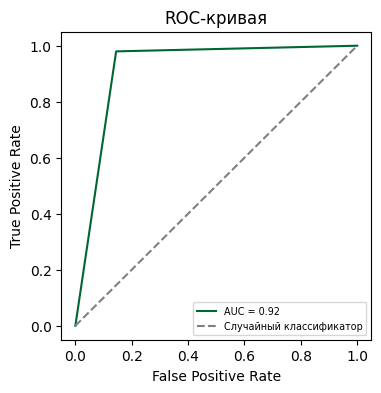

In [199]:
fp, tp, _ = roc_curve(y_pred, y_test)
auc = roc_auc_score(y_pred, y_test)
plt.figure(figsize=(4, 4))
plt.plot(fp, tp, color='#006633', label=f'AUC = {round(auc, 2)}')
plt.plot([0, 1], linestyle='--', color='gray', label='Случайный классификатор')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(fontsize='x-small', loc='lower right')
plt.show()